# Electric price prediction

## List
### Data preprocessiong
### EDA
### Covariant
### SK learn Model
* Regression Model
* Random Forest Model
### Darts Model
*
*
*
*
### Deep learning Model
*N-Beats
### Model comparison
### Daily Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from datetime import datetime, date
import seaborn as sns
import shutil
import warnings
warnings.filterwarnings("ignore")
import logging
from tqdm import tqdm


# model
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.dataprocessing import Pipeline
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts import concatenate
from darts.utils.statistics import plot_acf, check_seasonality
from darts.models import NaiveSeasonal
from darts.metrics import rmse, r2_score
from darts.models import NaiveDrift
from darts.models import NaiveEnsembleModel
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, ARIMA
from darts.utils.statistics import plot_residuals_analysis
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import torch
from darts.models import RNNModel
from darts.models.forecasting.prophet_model import Prophet
from darts.models import NBEATSModel
from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression #check

# mlflow
!pip install mlflow --q
import mlflow

## data preprocessing

In [2]:
# Load the electric dataset(CSV) into a Pandas DataFrame
df_el = pd.read_csv('Day-ahead Prices.csv')
# Select the desired columns
df_el = df_el[['MTU (CET/CEST)', 'Day-ahead Price [EUR/MWh]']]

# Rename the columns
df_el = df_el.rename(columns={'MTU (CET/CEST)': 'date', 'Day-ahead Price [EUR/MWh]': 'price'})

# Extract the first 16 characters from the 'date' column
df_el['date'] = df_el['date'].apply(lambda x: x[0:16])

# Drop rows where 'price' column is equal to '-'
df_el.drop(df_el[df_el['price'] == '-'].index, inplace=True)

median_price = df_el['price'].median()
df_el['price'].fillna(median_price, inplace=True)

# keep the data type(str, float64), if we did not the below work we meet an error.
df_el['date'] = pd.to_datetime(df_el['date'], format='%d.%m.%Y %H:%M')
df_el['price'] = df_el['price'].astype(float)
ts = TimeSeries.from_dataframe(df_el, time_col='date', value_cols = 'price', fill_missing_dates=False, freq='H')

# split
#

#split_date = pd.Timestamp(year=2023, month=5, day=1, hour=0)  # Change the month and day here
#train, test = ts.split_after(split_date)

df_el['date'] = pd.to_datetime(df_el['date'], format='%m.%d.%Y %H:%M')
ts = TimeSeries.from_dataframe(df_el, time_col='date', value_cols = 'price', fill_missing_dates=False, freq='H')
train, test = ts.split_after(pd.Timestamp("05.01.2023 00:00"))

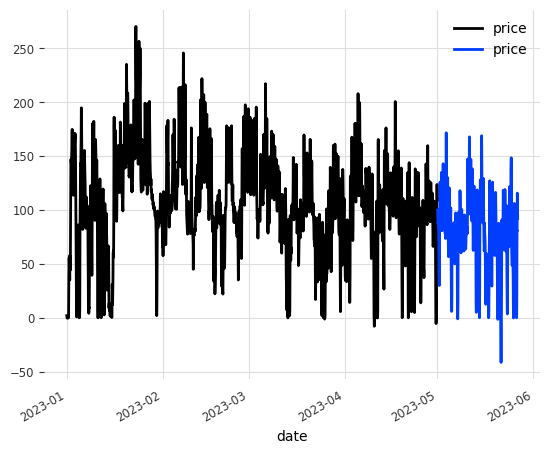

In [76]:
train.plot()
test.plot()

In [77]:
df_el.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3504 non-null   datetime64[ns]
 1   price   3504 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 54.9 KB


In [ ]:
import pandas as pd
import numpy as np

# Convert the 'price' column to a NumPy array
price_array = np.asarray(ts['price'])

# Convert the NumPy array to float using pd.to_numeric()
price_float = pd.to_numeric(price_array, errors='coerce')

# Create a new TimeSeries object with the updated 'price' column
ts_updated = ts.drop_columns('price')
ts_updated['price'] = price_float

# Use the updated TimeSeries object 'ts_updated' for further analysis

## EDA

In [69]:
df_el.to_csv('df_clean.csv')
df_el = pd.read_csv('df_clean.csv')
df_el.drop('Unnamed: 0', axis = 1, inplace = True)
df_eda = df_el.copy()

In [70]:
df_eda.head()

,date,price
0,01.01.2023 00:00,2.01
1,01.01.2023 01:00,1.38
2,01.01.2023 02:00,0.09
3,01.01.2023 03:00,0.08
4,01.01.2023 04:00,0.05


In [71]:
# data split for eda
df_eda[['date', 'time']] = df_eda['date'].str.split(' ', expand=True)
df_eda[['day', 'month', 'year']] = df_eda['date'].str.split('.', expand=True)
df_eda['hour'] = df_eda['time'].str.split(':', expand=True)[0]

In [72]:
df_eda.head()

,date,price,time,day,month,year,hour
0,01.01.2023,2.01,00:00,01,01,2023,00
1,01.01.2023,1.38,01:00,01,01,2023,01
2,01.01.2023,0.09,02:00,01,01,2023,02
3,01.01.2023,0.08,03:00,01,01,2023,03
4,01.01.2023,0.05,04:00,01,01,2023,04


In [37]:
df_eda['price'] = df_eda['price'].astype(float)
df_eda['hour'] = df_eda['hour'].astype(int)
df_eda['day'] = df_eda['day'].astype(int)
df_eda['month'] = df_eda['month'].astype(int)

<Axes: xlabel='month', ylabel='price'>

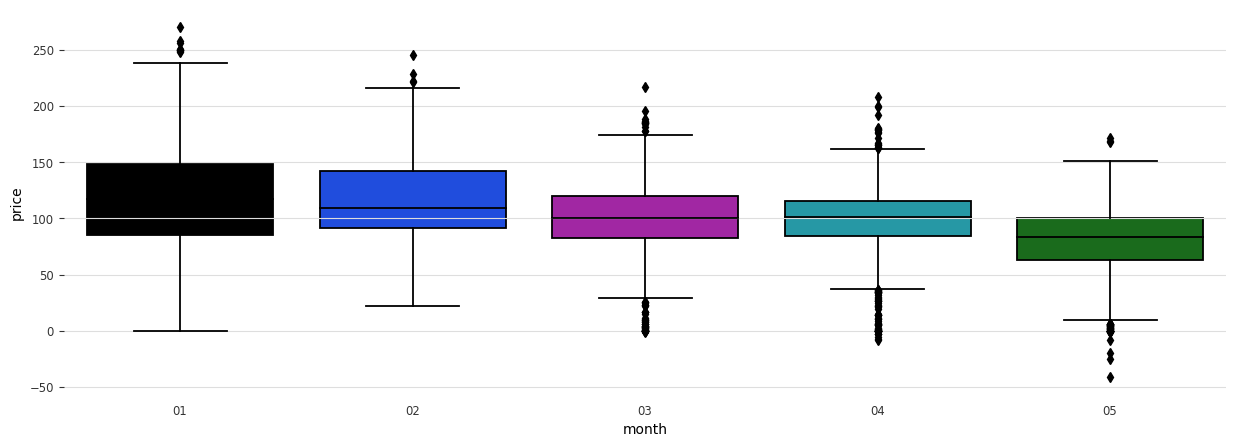

In [73]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df_eda, x='month', y='price')

<Axes: xlabel='day', ylabel='price'>

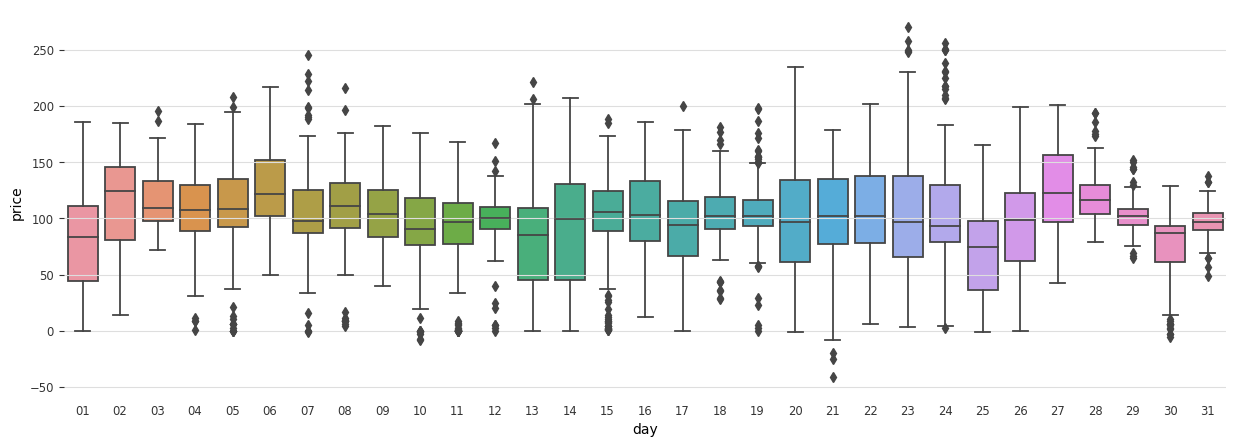

In [74]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df_eda, x='day', y='price')

<Axes: xlabel='hour', ylabel='price'>

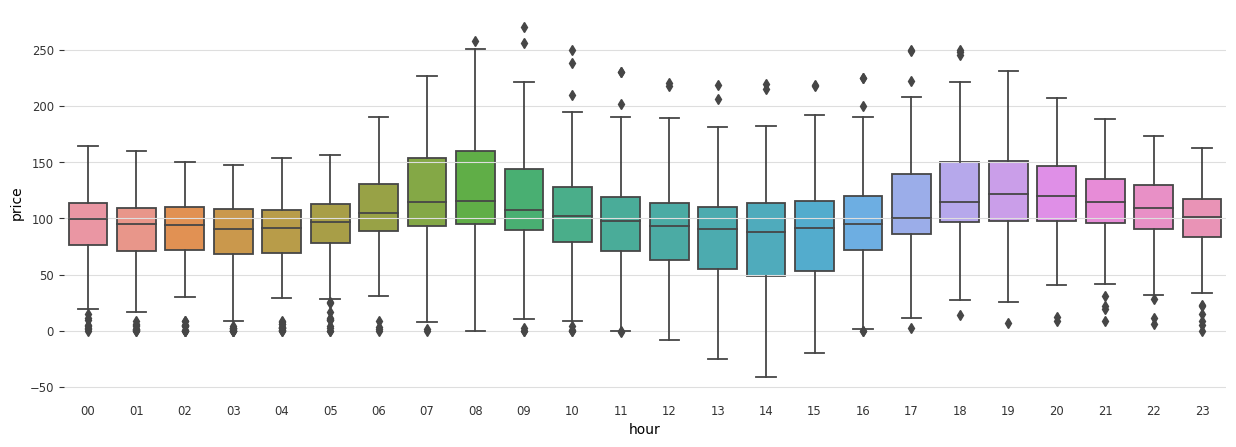

In [75]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df_eda, x='hour', y='price')

In [79]:
df_el.head()

,date,price
0,01.01.2023 00:00,2.01
1,01.01.2023 01:00,1.38
2,01.01.2023 02:00,0.09
3,01.01.2023 03:00,0.08
4,01.01.2023 04:00,0.05


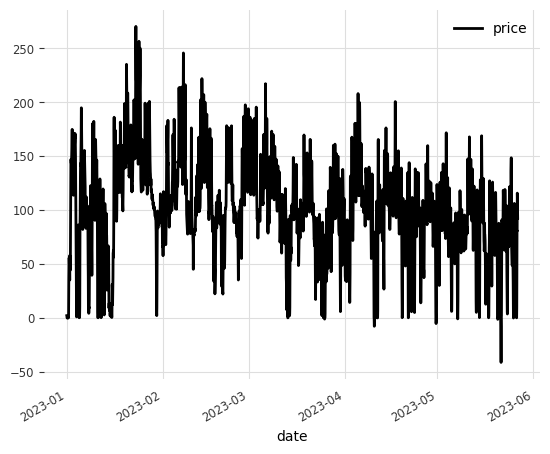

In [95]:
ts.plot()

##  Check the seasonality

There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.


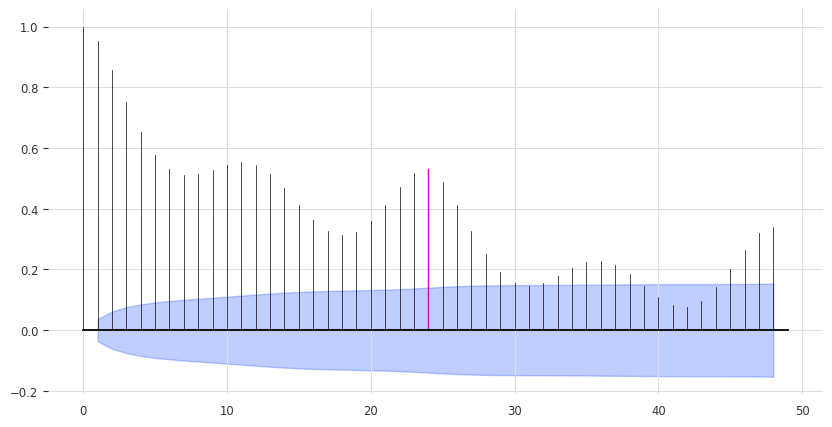

In [42]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=24, max_lag = 48, alpha=0.05)

for m in range(2, 24):
    is_seasonal, period = check_seasonality(train, m=24, max_lag = 48, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.


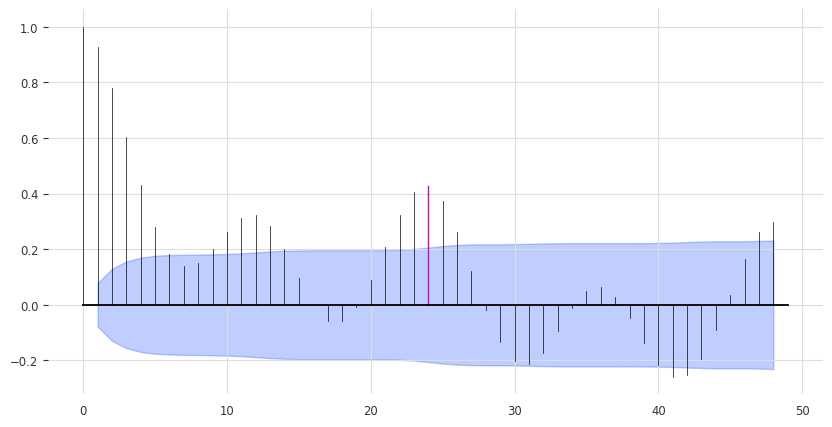

In [43]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(test, m=24, max_lag = 48, alpha=0.05)

for m in range(2, 24):
    is_seasonal, period = check_seasonality(test, m=24, max_lag = 48, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.
There is seasonality of order 24.


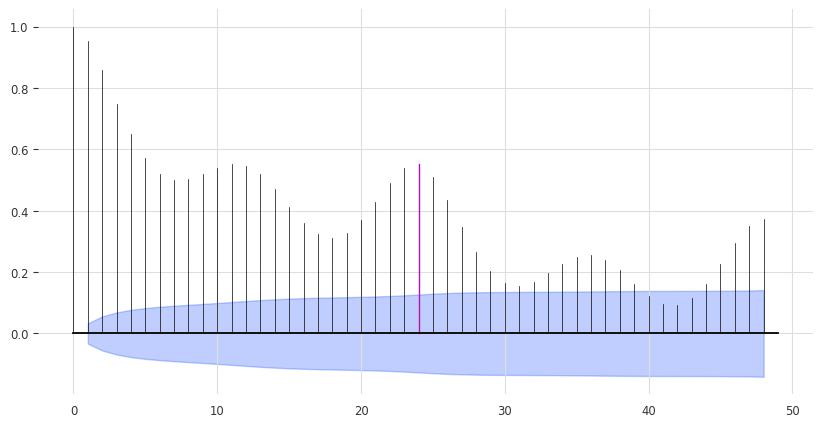

In [44]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(ts, m=24, max_lag = 48, alpha=0.05)

for m in range(2, 24):
    is_seasonal, period = check_seasonality(ts, m=24, max_lag = 48, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

## Covariates

In [12]:
# create day and time covariate series_basic one (I think our data is important day and hour relationship.)

hour_series = datetime_attribute_timeseries(
    pd.date_range(start=ts.start_time(), freq=ts.freq_str, periods=len(ts)),
    attribute="hour",
    one_hot=False)
day_series = datetime_attribute_timeseries(
    pd.date_range(start=ts.start_time(), freq=ts.freq_str, periods=len(ts)),
    attribute="day",
    one_hot=False)
month_series = datetime_attribute_timeseries(
    pd.date_range(start=ts.start_time(), freq=ts.freq_str, periods=len(ts)),
    attribute="month",
    one_hot=False)
year_series = datetime_attribute_timeseries(
    pd.date_range(start=ts.start_time(), freq=ts.freq_str, periods=len(ts)),
    attribute="year",
    one_hot=False)
weekday_series = datetime_attribute_timeseries(
    pd.date_range(start=ts.start_time(), freq=ts.freq_str, periods=len(ts)),
    attribute="dayofweek",
    one_hot=False)
weekofyear_series = datetime_attribute_timeseries(
    pd.date_range(start=ts.start_time(), freq=ts.freq_str, periods=len(ts)),
    attribute="weekofyear",
    one_hot=False)

In [13]:
# series_transform
hour_trasform = Scaler().fit_transform(hour_series)
day_transform = Scaler().fit_transform(day_series)
month_transform = Scaler().fit_transform(month_series)
year_transform = Scaler().fit_transform(year_series)
weekday_transform = Scaler().fit_transform(weekday_series)
weekofyear_transform = Scaler().fit_transform(weekofyear_series)

In [14]:
# we can use two cov, because our data is seasonality data based on time.
cov_day_hour = day_transform.stack(hour_series)
cov_all = hour_trasform.stack(day_transform).stack(month_transform).stack(year_transform).stack(weekday_transform).stack(weekofyear_transform)

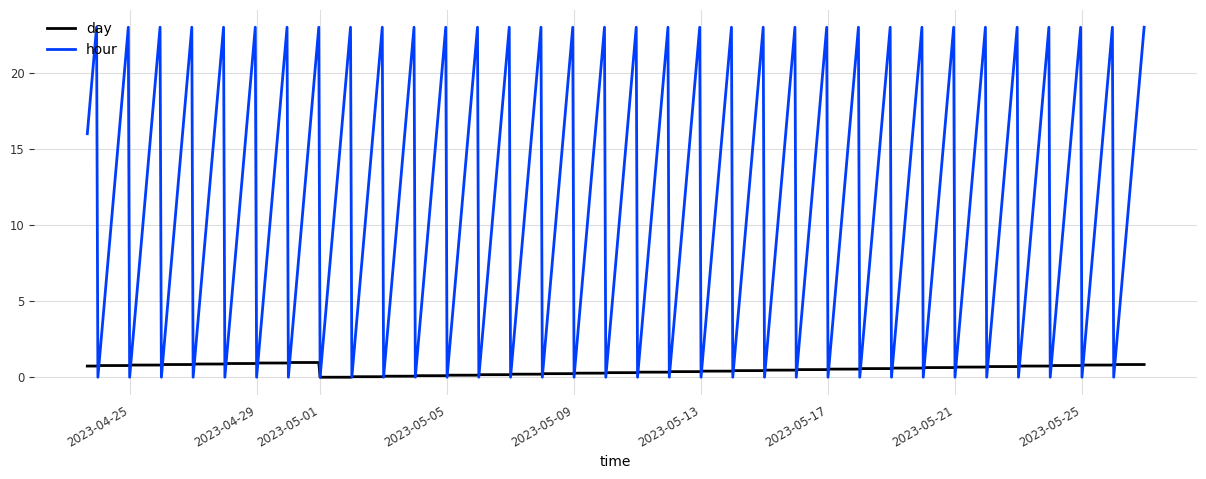

In [48]:
plt.figure(figsize=(15,5))
cov_day_hour[-800:].plot()

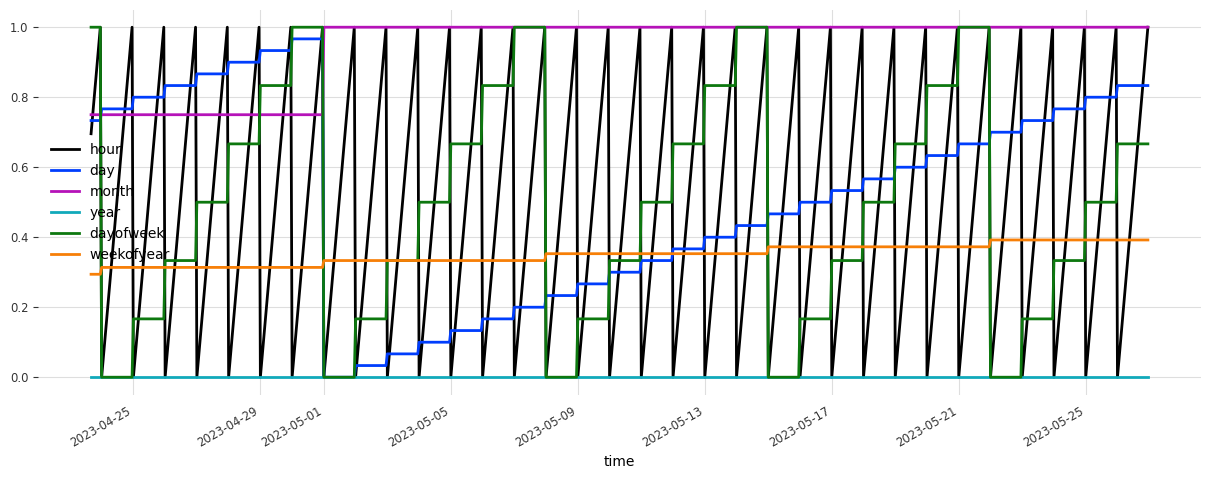

In [49]:
plt.figure(figsize=(15,5))
cov_all[-800:].plot()

## Sklearn Model

### 01_Linear Model
Why we use lag in timeseries data?
Time series analysis uses lags because the value of a time series at a given point in time can be dependent on the values of the series at previous points in time. In other words, the behavior of a time series at time t can be influenced by its values at times t-1, t-2, and so on.

A lag is simply a time shift of a time series by a certain number of time periods. For example, the first-order lag of a time series at time t is its value at time t-1. By analyzing the relationship between a time series and its lagged values, we can identify patterns, trends, and other characteristics of the series.

In [15]:
df_el.to_csv('df_clean.csv')
df_el = pd.read_csv('df_clean.csv')
df_el.drop('Unnamed: 0', axis = 1, inplace = True)
df_L = df_el.copy()
df_L = df_el.copy()
df_L['Time'] = np.arange(len(df_L.index))
df_L.set_index('date', inplace=True)

In [16]:
df_L['Lag_24'] = df_L['price'].shift(24)
#df_L['Lag_24'] = pd.to_numeric(df_L['Lag_24'], errors='coerce')
#df_L['price'] = pd.to_numeric(df_L['price'], errors='coerce')

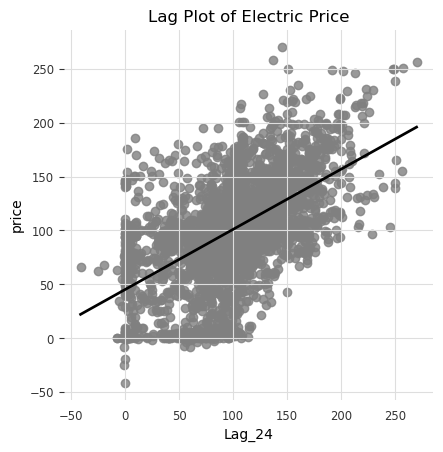

In [17]:
df_L_lag = df_L.reindex(columns=['price', 'Lag_24'])
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_24', y='price', data=df_L, ci=None, scatter_kws=dict(color='0.5'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Electric Price');

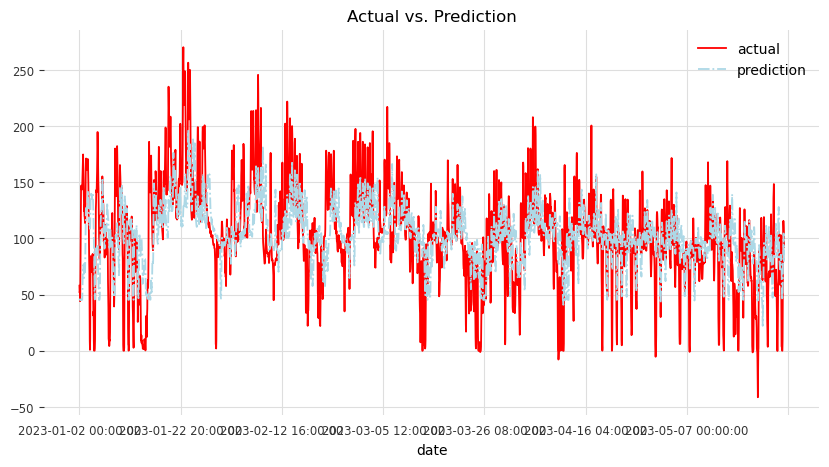

LR_MSE: 1297.904930889386
LR_RMSE: 36.026447658482596


In [18]:
# Training data with original data
X = df_L.loc[:, ['Time']]  # features
y = df_L.loc[:, 'price']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
y_pred = pd.Series(model.predict(X), index=X.index)

# Training data with Lag_24 data
X = df_L.loc[:, ['Lag_24']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df_L.loc[:, 'price']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

plot_params_actu = {'color': 'red', 'linestyle': '-'}
plot_params_pred = {'color': 'lightblue', 'linestyle': 'dashdot'}

plt.figure(figsize=(10, 5))
ax = y.plot(**plot_params_actu, label = 'actual')
ax = y_pred.plot(**plot_params_pred, label = 'prediction')

plt.title('Actual vs. Prediction')
plt.legend()
plt.show()

# evaluation
squared_diff = (y_pred - y) ** 2
    
# Calculate the mean squared error
mse = np.mean(squared_diff)
LR_rmse = np.sqrt(mse)
print('LR_MSE:', mse)
print('LR_RMSE:', LR_rmse)

### 02_Random Forest Model

Moving average is a commonly used technique in time series analysis for smoothing out fluctuations and identifying underlying trends or patterns in the data. 
1. smoothing
2. Trend identification
3. Seasonality detection
4. Forecasting

In [19]:
df_el = pd.read_csv('df_clean.csv')
df_el.drop('Unnamed: 0', axis = 1, inplace = True)
df_rm = df_el.copy()
df_rm.set_index('date', inplace=True)

# using moving average
df_rm['moving_avg_24'] = df_rm['price'].rolling(window=24).mean()
df_rm['moving_avg_24'].fillna(df_rm['moving_avg_24'].mean(), inplace=True)

# Split the data into train and test sets
train = df_rm[:'2023-05-01 00:00:00']
test = df_rm['2023-05-01 00:00:00':]

X_train = train.drop('price', axis=1)
y_train = train['price']
X_test = test.drop('price', axis=1)
y_test = test['price']

In [113]:
test.head()

,price,moving_avg_24
date,,
2023-05-01 00:00:00,109.90,68.729167
2023-05-01 01:00:00,99.90,69.096250
2023-05-01 02:00:00,95.49,69.392500
2023-05-01 03:00:00,89.98,69.574583
2023-05-01 04:00:00,87.29,69.648333


In [20]:
# data convert
#y_pred = pd.to_numeric(y_pred)
#y_test = pd.to_numeric(y_test)

# rf model fit and pred
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
squared_diff = (y_pred - y_test) ** 2
    
# Calculate the mean squared error
mse = np.mean(squared_diff)
RF_rmse = np.sqrt(mse)
print('MSE:', mse)
print('RMSE:', RF_rmse)

MSE: 1588.8318562132506
RMSE: 39.8601537404618


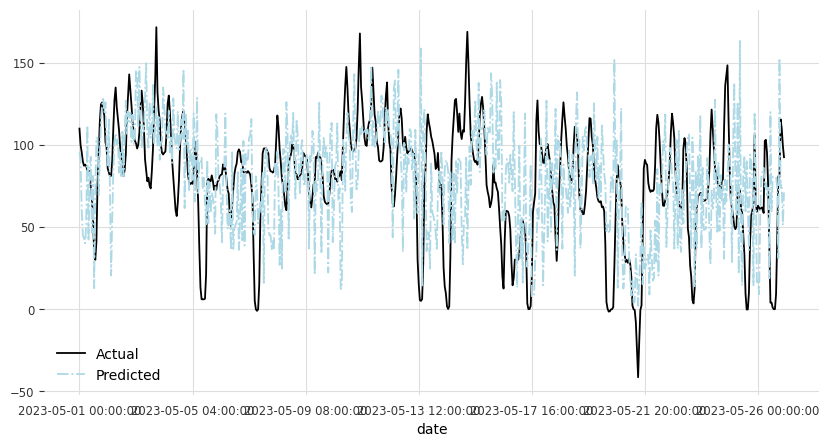

In [115]:
y_pred_df = pd.DataFrame(y_pred, index=y_test.index, columns=['price'])

# Plot the actual and predicted prices
plt.figure(figsize=(10, 5))
plot_params_actu = {'color': 'black'}
plot_params_pred = {'color': 'lightblue', 'linestyle': 'dashdot'}

ax = y_test.plot(**plot_params_actu)
ax = y_pred_df.plot(ax=ax, **plot_params_pred)
plt.legend(['Actual', 'Predicted'])
plt.show()

## Build DART Models

### 01_Ensemble model, combined_forecast with NaiveSeasonal model & Drift 

Model NaiveSeasonal() obtains RMSE: 46.76%


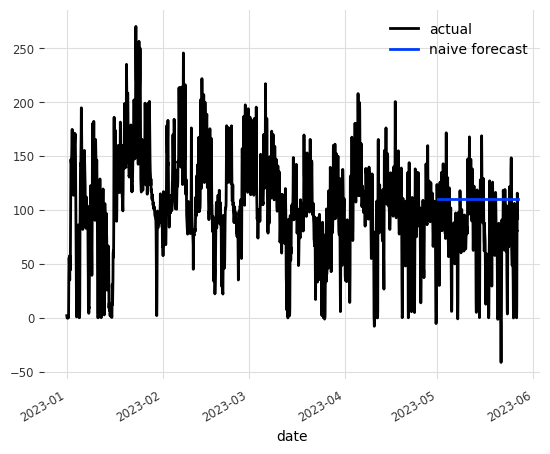

In [3]:
# Convert the train data to a TimeSeries object
#train_ts = TimeSeries.from_dataframe(train, 'date', 'price')

# Fit the NaiveSeasonal model
seasonal_model = NaiveSeasonal()
seasonal_model.fit(train)

# Forecast using the model
seasonal_forecast = seasonal_model.predict(len(test))

# Calculate RMSE
navieseasonal_rmse = rmse(test, seasonal_forecast)
print("Model {} obtains RMSE: {:.2f}%".format(seasonal_model, navieseasonal_rmse))

ts.plot(label="actual", alpha=0.05)
seasonal_forecast.plot(label="naive forecast", alpha=0.05)

Root Mean absolute percentage error for the combined naive drift + seasonal: 56.97%.


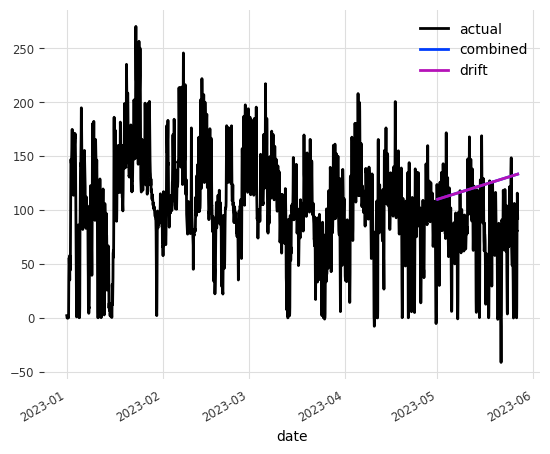

In [4]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(len(test))

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()
combined_forecast_rmse = rmse(ts, combined_forecast)
print(
    "Root Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        combined_forecast_rmse))

ts.plot(label="actual")
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

In [5]:
models = [NaiveDrift(), NaiveSeasonal(24)]

ensemble_model = NaiveEnsembleModel(models=models)
ensemble_model.fit(train)
ensemble_pred = ensemble_model.predict(len(test))
ensemble_rmse = rmse(test, ensemble_pred)
print('ensemble_rmse: {:.2f}%'.format(ensemble_rmse))


ensemble_rmse: 34.48%


  0%|          | 0/1380 [00:00<?, ?it/s]

RMSE = 35.74


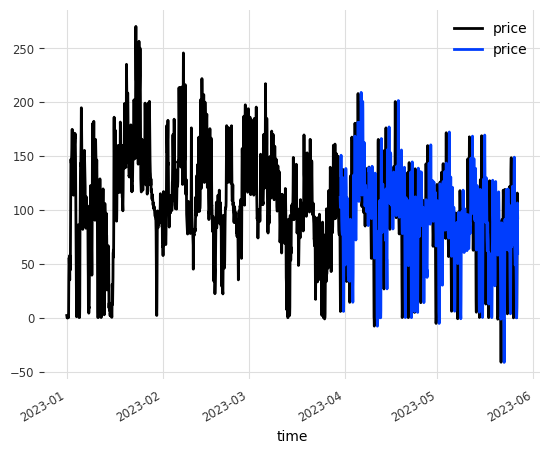

In [6]:
models = [NaiveDrift(), NaiveSeasonal(24)]

ensemble_model = NaiveEnsembleModel(models=models)

# we will see our ensemble model ability
backtest = ensemble_model.historical_forecasts(
    ts, start=0.6, forecast_horizon=24, verbose=True
)
ensemble_rmse = rmse(backtest, ts)
print("RMSE = %.2f" % (ensemble_rmse))
ts.plot()
backtest.plot()

### 02_ ExponentialSmoothing, TBATS, AutoARIMA

In [106]:
# we will see other model
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(test))
    print("model {} obtains RMSE: {:.2f}%".format(model, rmse(test, forecast)))


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())

model ExponentialSmoothing() obtains RMSE: 205.57%
model TBATS() obtains RMSE: 36.17%
model AutoARIMA() obtains RMSE: 36.86%


  0%|          | 0/1403 [00:00<?, ?it/s]

RMSE = 11.01%


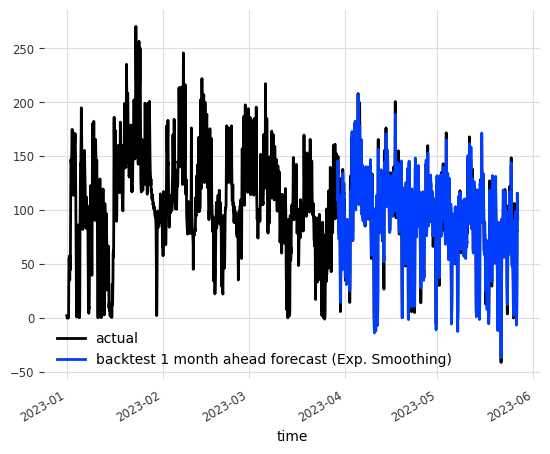

In [28]:
model_es = ExponentialSmoothing(seasonal_periods=24)
historical_forecast_es = model_es.historical_forecasts(
    ts, start=0.6, forecast_horizon=1, verbose=True)

ts.plot(label="actual")
historical_forecast_es.plot(label="backtest 1 month ahead forecast (Exp. Smoothing)")
es_rmse = rmse(historical_forecast_es, ts)
print("RMSE = {:.2f}%".format(es_rmse))

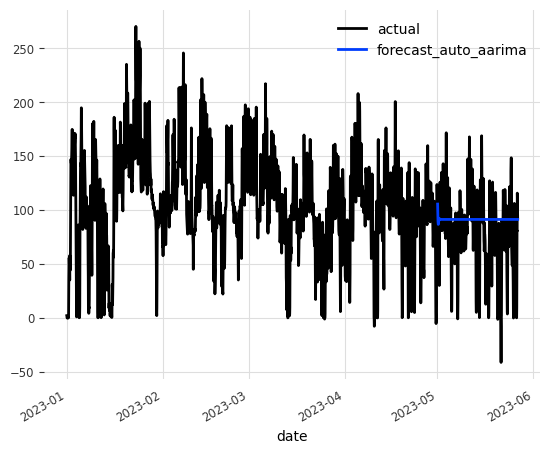

In [108]:
model_aarima = AutoARIMA()
model_aarima.fit(train)
prediction_aarima = model_aarima.predict(len(test))
ts.plot(label = 'actual')
prediction_aarima.plot(label ='forecast_auto_aarima')

### 03_Facebook_Prophet Model

In [8]:
season=({'name': 'price',
         'seasonal_periods': 24, 
         'fourier_order':1000})

19:38:00 - cmdstanpy - INFO - Chain [1] start processing
19:38:25 - cmdstanpy - INFO - Chain [1] done processing


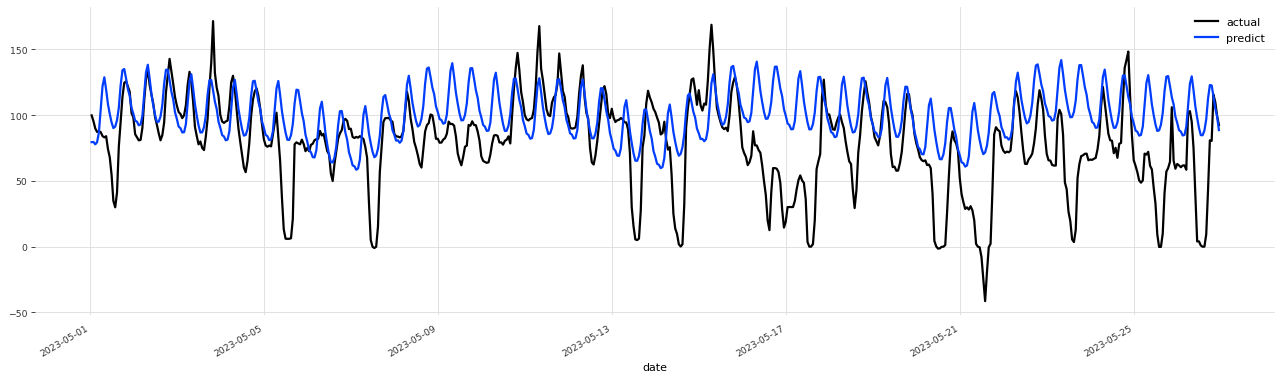

RMSE :  38.37358544246842
R2 score :  -0.2334862410644456


In [9]:
model= Prophet(add_seasonalities = season)
model.fit(train)
pred_normal = model.predict(len(test))

plt.figure(figsize=(20, 5), dpi=80)
test.plot(label="actual")
pred_normal.plot(label="predict")
plt.show()

prophet_rmse_normal = rmse(test, pred_normal)
prophet_r2_normal   = r2_score(test, pred_normal)
print("RMSE : ", prophet_rmse_normal)
print("R2 score : ", prophet_r2_normal)

19:38:30 - cmdstanpy - INFO - Chain [1] start processing
19:38:33 - cmdstanpy - INFO - Chain [1] done processing
19:38:37 - cmdstanpy - INFO - Chain [1] start processing
19:38:38 - cmdstanpy - INFO - Chain [1] done processing
19:38:43 - cmdstanpy - INFO - Chain [1] start processing
19:38:44 - cmdstanpy - INFO - Chain [1] done processing
19:38:49 - cmdstanpy - INFO - Chain [1] start processing
19:38:50 - cmdstanpy - INFO - Chain [1] done processing
19:38:54 - cmdstanpy - INFO - Chain [1] start processing
19:38:55 - cmdstanpy - INFO - Chain [1] done processing
19:38:59 - cmdstanpy - INFO - Chain [1] start processing
19:39:01 - cmdstanpy - INFO - Chain [1] done processing
19:39:05 - cmdstanpy - INFO - Chain [1] start processing
19:39:06 - cmdstanpy - INFO - Chain [1] done processing
19:39:11 - cmdstanpy - INFO - Chain [1] start processing
19:39:12 - cmdstanpy - INFO - Chain [1] done processing
19:39:16 - cmdstanpy - INFO - Chain [1] start processing
19:39:18 - cmdstanpy - INFO - Chain [1]

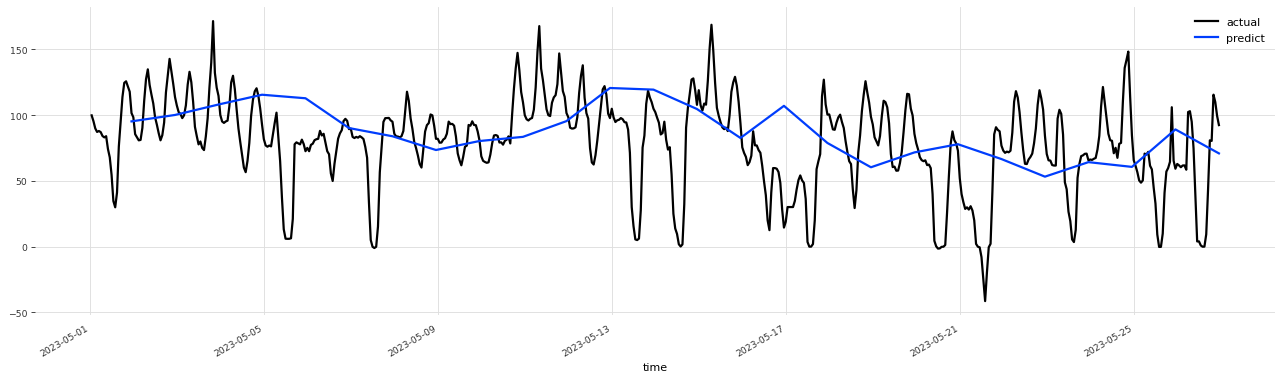

IndexError: tuple index out of range

In [10]:
# I am not sure we will use this one.
pred = model.historical_forecasts(series=ts, forecast_horizon=24,
                                  stride=24,
                                  train_length=336,
                                  start=pd.Timestamp("05.01.2023 00:00"),
                                  verbose=False)
plt.figure(figsize=(20, 5), dpi=80)
test.plot(label="actual")
pred.plot(label="predict")
plt.show()


# Convert the test and pred TimeSeries to numpy arrays
test_values = np.array(test)
pred_values = np.array(pred)

prophet_rmse = rmse((test_values, pred_values))
prophet_r2 = r2_score(test, pred)
print("RMSE : ", prophet_rmse)
print("R2 score : ", prophet_r2)

## Deep Learning Model

### RNN

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

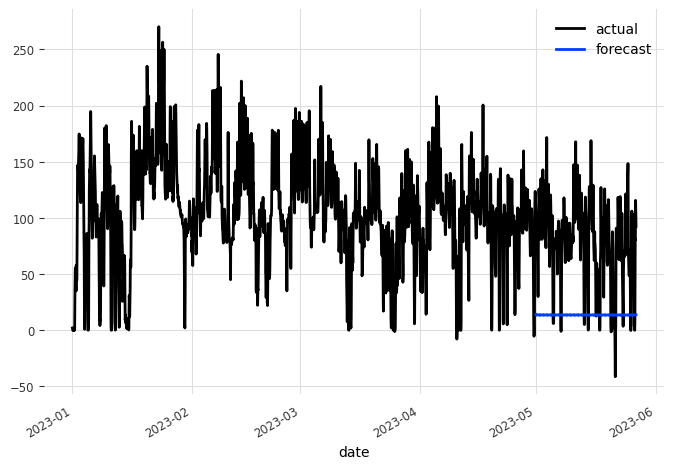

In [15]:
my_model = RNNModel(
    model="LSTM",
    hidden_dim=5, #5, 10, 15
    dropout=0,
    batch_size=72, 
    n_epochs=50, # try it: 30, 50, 100
    optimizer_kwargs={"lr": 1e-3},
    model_name="ELPrice_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=72,
    force_reset=True,
    save_checkpoints=True
)

my_model.fit(
    train,
    future_covariates=cov_day_hour,
    val_series=test,
    val_future_covariates=cov_day_hour,
    verbose=False)

rnn0_rmse = rmse(train, test)

pred_series = my_model.predict(len(test), future_covariates=cov_day_hour)
plt.figure(figsize=(8, 5))
ts.plot(label="actual")
pred_series.plot(label="forecast")

### Nbeats

In [16]:
# Log parameters
model_nbeats = NBEATSModel(
    input_chunk_length=168,
    output_chunk_length=24,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=50,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name="nbeats_run",
)

model_nbeats.fit(train, val_series=test, verbose=False)
pred = model_nbeats.predict(len(test))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

In [ ]:
pred = model_nbeats.historical_forecasts(ts,
                                         forecast_horizon=24, 
                                         stride=24, 
                                         train_length=336, 
                                         start=pd.Timestamp("05.01.2023 00:00"), 
                                         verbose=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.8 M 
---------------------------------------------------
8.8 M     Trainable params
3.6 K     Non-trainable params
8.8 M     Total params
35.231    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.8 M 
---------------------------------------------------
8.8 M     Trainable params
3.6 K     Non-trainable params
8.8 M     Total params
35.231    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.8 M 
---------------------------------------------------
8.8 M     Trainable params
3.6 K     Non-trainable params
8.8 M     Total params
35.231    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.8 M 
---------------------------------------------------
8.8 M     Trainable params
3.6 K     Non-trainable params
8.8 M     Total params
35.231    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.8 M 
---------------------------------------------------
8.8 M     Trainable params
3.6 K     Non-trainable params
8.8 M     Total params
35.231    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.8 M 
---------------------------------------------------
8.8 M     Trainable params
3.6 K     Non-trainable params
8.8 M     Total params
35.231    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.8 M 
---------------------------------------------------
8.8 M     Trainable params
3.6 K     Non-trainable params
8.8 M     Total params
35.231    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.8 M 
---------------------------------------------------
8.8 M     Trainable params
3.6 K     Non-trainable params
8.8 M     Total params
35.231    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.8 M 
---------------------------------------------------
8.8 M     Trainable params
3.6 K     Non-trainable params
8.8 M     Total params
35.231    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

## Compare the Models

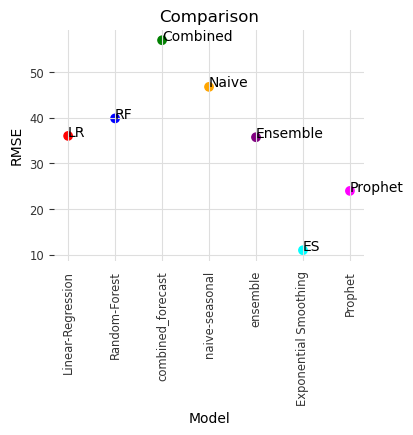

In [61]:
import matplotlib.pyplot as plt

# Sample RMSE data
rmse = {
    "Linear-Regression": LR_rmse,
    "Random-Forest": RF_rmse,
    "combined_forecast": combined_forecast_rmse,
    "naive-seasonal": navieseasonal_rmse,
    "ensemble": ensemble_rmse,
    "Exponential Smoothing": es_rmse,
    "Prophet": prophet_rmse_normal,
}

X = list(rmse.keys())
y = list(rmse.values())

# Define colors and labels for each point

colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta']
labels = ['LR', 'RF', 'Combined', 'Naive', 'Ensemble', 'ES', 'Prophet']

# Create a scatter plot
plt.figure(figsize=(4, 3))
plt.scatter(X, y, c=colors)

# Add labels and title
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Comparison')

# Add custom labels to each point
for i, label in enumerate(labels):
    plt.text(X[i], y[i], label)

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Show the chart
plt.show()


## Select  Exponential Smoothing Model by Comparison

In [50]:
# Load the electric dataset(CSV) into a Pandas DataFrame
df_el = pd.read_csv('Day-ahead Prices.csv')
# Select the desired columns
df_el = df_el[['MTU (CET/CEST)', 'Day-ahead Price [EUR/MWh]']]

# Rename the columns
df_el = df_el.rename(columns={'MTU (CET/CEST)': 'date', 'Day-ahead Price [EUR/MWh]': 'price'})

# Extract the first 16 characters from the 'date' column
df_el['date'] = df_el['date'].apply(lambda x: x[0:16])

# Drop rows where 'price' column is equal to '-'
df_el.drop(df_el[df_el['price'] == '-'].index, inplace=True)

median_price = df_el['price'].median()
df_el['price'].fillna(median_price, inplace=True) 

df_el['date'] = pd.to_datetime(df_el['date'], format='%d.%m.%Y %H:%M')
ts = TimeSeries.from_dataframe(df_el, time_col='date', value_cols = 'price', fill_missing_dates=False, freq='H')

In [53]:
today = date.today()
print(today)

2023-05-26


In [54]:
# connect mlflow

mlflow.set_experiment("elprice_predictor")

# Start MLflow run
mlflow.start_run(run_name="model_es_pred", nested=True)

# save all parameters
mlflow.pytorch.autolog() 

  0%|          | 0/57 [00:00<?, ?it/s]

RMSE = 24.56%


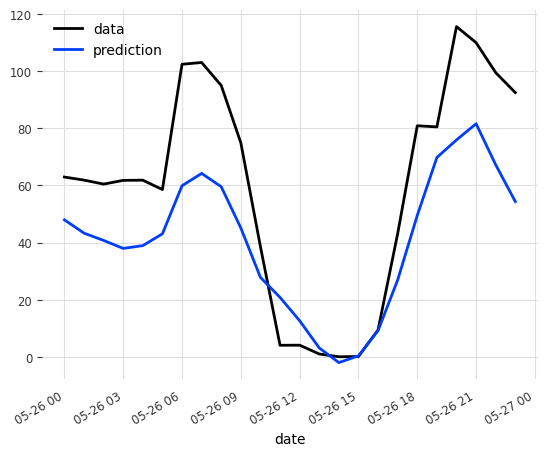

In [55]:
# one week

train = ts[-168:-24] # 1week
test = ts[-24:] # 1day

model_es = ExponentialSmoothing(seasonal_periods=24)
model_es.fit(train)

historical_fcast_es = model_es.historical_forecasts(
    train, start=0.6, forecast_horizon=3, verbose=True)
pred = model_es.predict(len(test))


test.plot(label="data")
pred.plot(label="prediction")
print("RMSE = {:.2f}%".format(rmse(pred, test)))

# save excel file
df_predict = pred.pd_dataframe()
df_predict
df_predict.to_csv('1 week_price_{}.csv'.format(today))

  0%|          | 0/854 [00:00<?, ?it/s]

RMSE = 22.37%


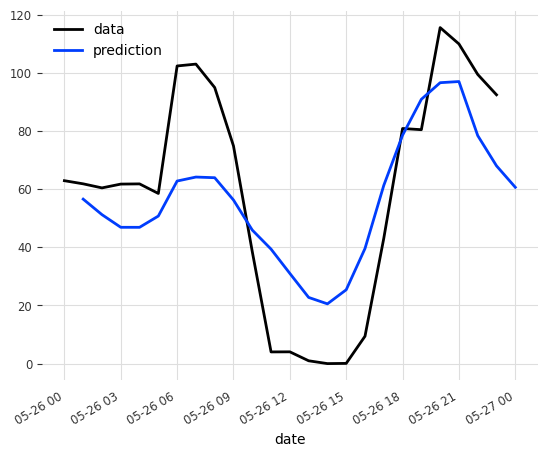

In [56]:
# training 3months
train_3m = ts[-2160:-23]
test_3m = ts[-24:]

model_es = ExponentialSmoothing(seasonal_periods=24)
model_es.fit(train_3m)

historical_fcast_es = model_es.historical_forecasts(
    train_3m, start=0.6, forecast_horizon=3, verbose=True)
pred = model_es.predict(len(test_3m))


test_3m.plot(label="data")
pred.plot(label="prediction")
print("RMSE = {:.2f}%".format(rmse(pred, test_3m)))

# save excel file
df_predict = pred.pd_dataframe()
df_predict
df_predict.to_csv('1 month_price_{}.csv'.format(today))

In [57]:
# Register the model in the MLflow registry
run_id_active = mlflow.active_run().info.run_id
model_uri = "runs:/" + run_id_active + "/elprice_predictor"
model_version = mlflow.register_model(model_uri, "model_es_pred")

mlflow.end_run()

Registered model 'model_es_pred' already exists. Creating a new version of this model...
2023/05/26 18:29:41 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: model_es_pred, version 2
Created version '2' of model 'model_es_pred'.
